In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table

import corner

from collections import OrderedDict
import time


Bad key "text.kerning_factor" on line 4 in
/Users/alexji/anaconda/envs/newpy36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Crater 2

This is data taken from AAT/AAO as part of the S5 collaboration (Ji et al. in prep).
We targeted a diffuse dwarf galaxy Crater 2 and want to measure its velocity and metallicity dispersion.
We obtained multifiber spectroscopy of ~300 stars and used a pipeline to measure the radial velocities and metallicities, obtaining ~150 stars with good measurements.
Within the field of view, targets are selected based off of their color-magnitude diagrams and proper motions. This can still leave substantial contamination from disk or halo stars that can be separated using the stellar velocities and metallicities.

We will fit a Gaussian mixture model to this data using `emcee`.

In [2]:
tab = Table.read("DR2.2beta_extra_Crater2.fits")

In [3]:
quality_cuts = (tab["best_sn_1700d"] > 4) & (tab["vel_calib_std"] < 10) & (np.abs(tab["vel_calib"]) < 500)
tab = tab[quality_cuts]

## Remove bad [Fe/H] without removing their velocity
tab["feh_calib_std"][tab["feh_calib_std"] > 0.5] = 99.
## Remove binary candidates without removing their feh
tab["vel_calib_std"][tab["bincand"]] = 999.

In [4]:
len(tab)

149

In [5]:
tab.colnames

['vel_calib',
 'vel_calib_std',
 'feh50',
 'feh_calib_std',
 'best_sn_1700d',
 'bincand']

[(-100, 400),
 Text(0, 0.5, 'vhel (km/s)'),
 (-4, 1),
 Text(0.5, 0, '[Fe/H] (dex)')]

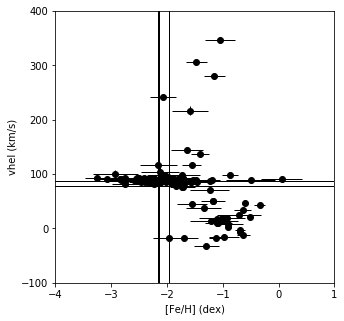

In [6]:
## Pull out the relevant data columns
rv = tab["vel_calib"] # heliocentric radial velocity
rverr = tab["vel_calib_std"]

feh = tab["feh50"]
feherr = tab["feh_calib_std"]

fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(feh, rv, xerr=feherr, yerr=rverr, fmt='o', elinewidth=1, color='k')
ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))


Text(0.5, 0, '[Fe/H]')

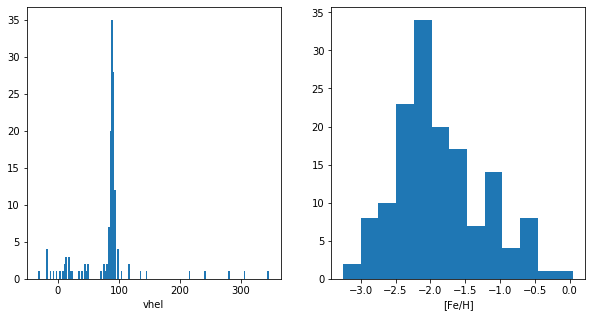

In [7]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(rv, bins='auto');
axes[0].set_xlabel("vhel")
axes[1].hist(feh, bins='auto');
axes[1].set_xlabel("[Fe/H]")

By eye, there are 2-3 components. We will model these as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 14 parameters.

# Creating a Stan model

Stan is actually a completely separate language, and pystan is just an interface to call Stan.
It's pretty confusing the first time you go through all of this so let me just show an example.

In [8]:
!cat example.stan

data {
    int K; // number of components
    int N; // number of measurements
    real feh[N];
    real feherr[N];
    real rv[N];
    real rverr[N];
}

parameters {
    simplex[K] p; // mixing proportion
    real<lower=-500, upper=500> muv[K];
    real<lower=-5, upper=1> mufeh[K];
    real<lower=-2.0, upper=6.0> loge_sigmav[K]; 
    real<lower=-5.0, upper=1.0> loge_sigmafeh[K];
}

transformed parameters {
    real sigmav[K] = exp(loge_sigmav);
    real sigmafeh[K] = exp(loge_sigmafeh);
}

model {
    // Initialize log of mixing proportions
    vector[K] logp = log(p);
    p[1] ~ uniform(0.6,1.0);
    
    // Prior on the component velocities for identifiability
    muv[1] ~ normal(90, 5);
    mufeh[1] ~ normal(-2.0, 0.3);
    muv[2] ~ normal(150, 40);
    mufeh[2] ~ normal(-1.5, 0.3);
    muv[3] ~ normal(0, 30);
    mufeh[3] ~ normal(-1.0, 0.3);
    loge_sigmav[1] ~ normal(1.0,1.0);
    loge_sigmav[2] ~ normal(4.5,1.0);
    loge_sigmav[3] ~ normal(4.0,1.0);
    
    // Mixture model 

Note the semicolons are necessary because C++.

The `data` block is stuff that you pass into stan. Self explanatory. In our case K=3.

The `parameters` block is the parameters that Stan will sample. You can define a uniform range here. There are several special variable types (e.g. you want a 2D unit vector variable for your angles, there are covariance matrix variables that are guaranteed to be positive (semi?)definite).

The `transformed parameters` block is any transformations you want to do to the sampled parameters. In our case we want our prior to be uniform in log sigmav (the Jeffreys prior), so we have our actual parameters as log (base e) and the values used in our model as transformed parameters.

The `model` block specifies the log likelihood computation. There are lots of special variable names, e.g. `target` is the log likelihood, functions ending in `_lpdf` are log pdfs.
You can find the available functions to use online.



The code I use is usually drawn from looking somewhere here, e.g. this section for mixture modeling:
https://mc-stan.org/docs/2_20/stan-users-guide/mixture-modeling-chapter.html

These are important to read if you are interested in using Stan for mixture models like this
* https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html
* https://mc-stan.org/docs/2_20/stan-users-guide/label-switching-problematic-section.html


# Run Stan
I've taken some code from Andy Casey that loads and saves Stan models

In [9]:
import stan_utils as stan

# This compiles the model, printing error messages to the terminal. The result is saved to `example.stan.cached`
model = stan.load_stan_model("example.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68aaac5c285eaffe5abfe2d002a6a9e9 NOW.


# Optimize parameters: not needed

Stan is generally fast enough at sampling that you don't have to worry too much about initialization, it will just explore the whole space. But you can do it if you want.

# Run the sampler

In [10]:
numiter = 5000
nchains = 4 # I think it parallelizes over this
## This stuff goes into the data block in the Stan program
data_dict = {
    "K":3,
    "N":len(rv),
    "rv":rv,
    "rverr":rverr,
    "feh":feh,
    "feherr":feherr,
    #"murvprior":[90, 185, 20],
    #"murvsigprior":[20,50,20],
    #"mufeprior":[-2.2, -1.5, -0.5],
}
## You can initialize values for the chains here if you want and pass it to stan.sampling_kwds below
init = {"p":[0.8, 0.1, 0.1], "loge_sigmav":[1.0, 4.5, 4.0], "loge_sigmafeh":[-1.0, 0.0, -0.5]}

In [11]:
%%time
samples = model.sampling(**stan.sampling_kwds(
    data=data_dict,
    chains=nchains, 
    verbose=True,
    init=init,
    iter=numiter
))

CPU times: user 148 ms, sys: 68.6 ms, total: 217 ms
Wall time: 19.4 s


The compiling takes a while, but the sampling takes like a few dozen seconds!
Look at the terminal to see the progress being printed out.

If you just print the variable `samples`, it computes a bunch of information about percentiles.
What you care about for whether things worked is n_eff and Rhat.
If Rhat = 1.00 that means the variable has converged nicely. n_eff is how many "effective" samples you have for that variable in the chain. So if you want to estimate a 99th percentile, you need at least 100 effective samples, and probably 10x that.

In [12]:
samples

Inference for Stan model: anon_model_68aaac5c285eaffe5abfe2d002a6a9e9.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p[1]               0.71  4.0e-4   0.04   0.64   0.69   0.71   0.74   0.78   8651    1.0
p[2]                0.1  3.8e-4   0.03   0.05   0.08    0.1   0.12   0.17   6984    1.0
p[3]               0.18  4.5e-4   0.04   0.11   0.16   0.18   0.21   0.26   6561    1.0
muv[1]            89.14  2.7e-3   0.33  88.48  88.91  89.14  89.36  89.78  15064    1.0
muv[2]            150.9    0.32  27.96  98.16  131.6 150.28 169.49 207.46   7738    1.0
muv[3]            19.62    0.09    7.3   6.05  14.53  19.46  24.52  34.51   7214    1.0
mufeh[1]          -2.14  4.4e-4   0.04  -2.22  -2.17  -2.14  -2.11  -2.05   8960    1.0
mufeh[2]          -1.55  1.2e-3    0.1  -1.73  -1.62  -1.56  -1.49  -1.32   6991    1.0
mufeh[3]          

In [13]:
model_labels = ["p","muv","mufeh","sigmav","sigmafeh"]

In [14]:
output = samples.extract(model_labels)
nparam = 3*len(model_labels)
ntot = output["p"].shape[0]
chain = np.zeros((ntot, nparam))
jj = 0

param_labels = []
for label in model_labels:
    for j in range(3):
        chain[:,jj] = output[label][:,j]
        param_labels.append(label+str(j))
        jj += 1

In [15]:
chain.shape

(10000, 15)

# Plots
You can treat the chain the way you would with emcee output (the rest of this code is identical to before). The four chains are just concatenated next to each other. This is useful to know because if the traceplot pieces are very distinct, that means the model is hitting local minima. It requires futzing with the initial conditions and the parameter priors for it to work out so that it all looks the same.

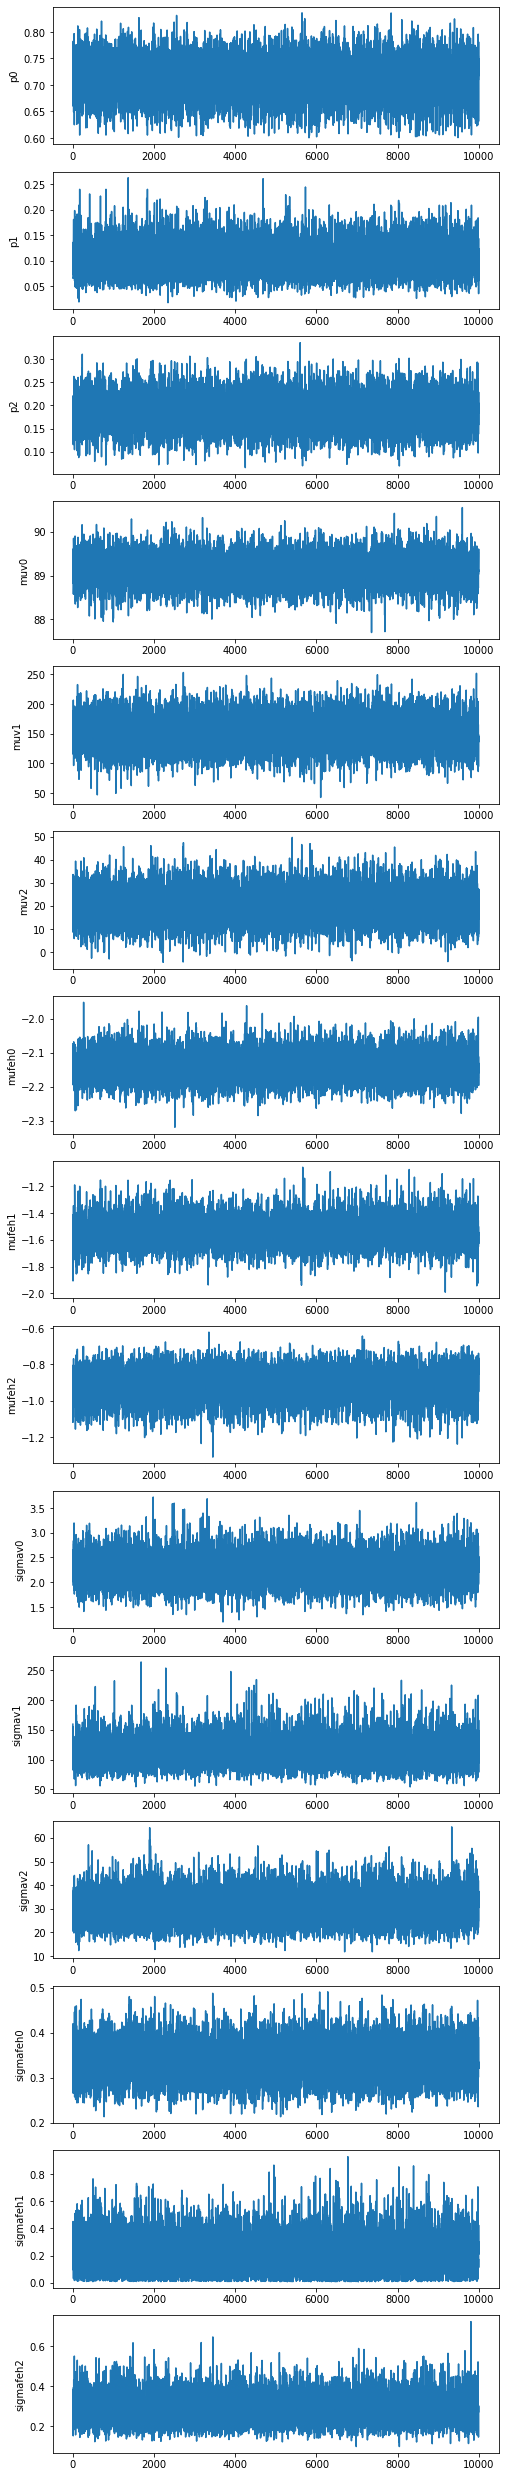

In [16]:
Nrow = chain.shape[1]
fig, axes = plt.subplots(Nrow, figsize=(8,Nrow*3))
for i, ax in enumerate(axes.flat):
    ax.plot(chain[:,i])
    ax.set_ylabel(param_labels[i])

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round and unimodal. If not, that means the model is multimodal, or (more commonly in mixture models) that you did not specify the model enough for it to be unimodal.

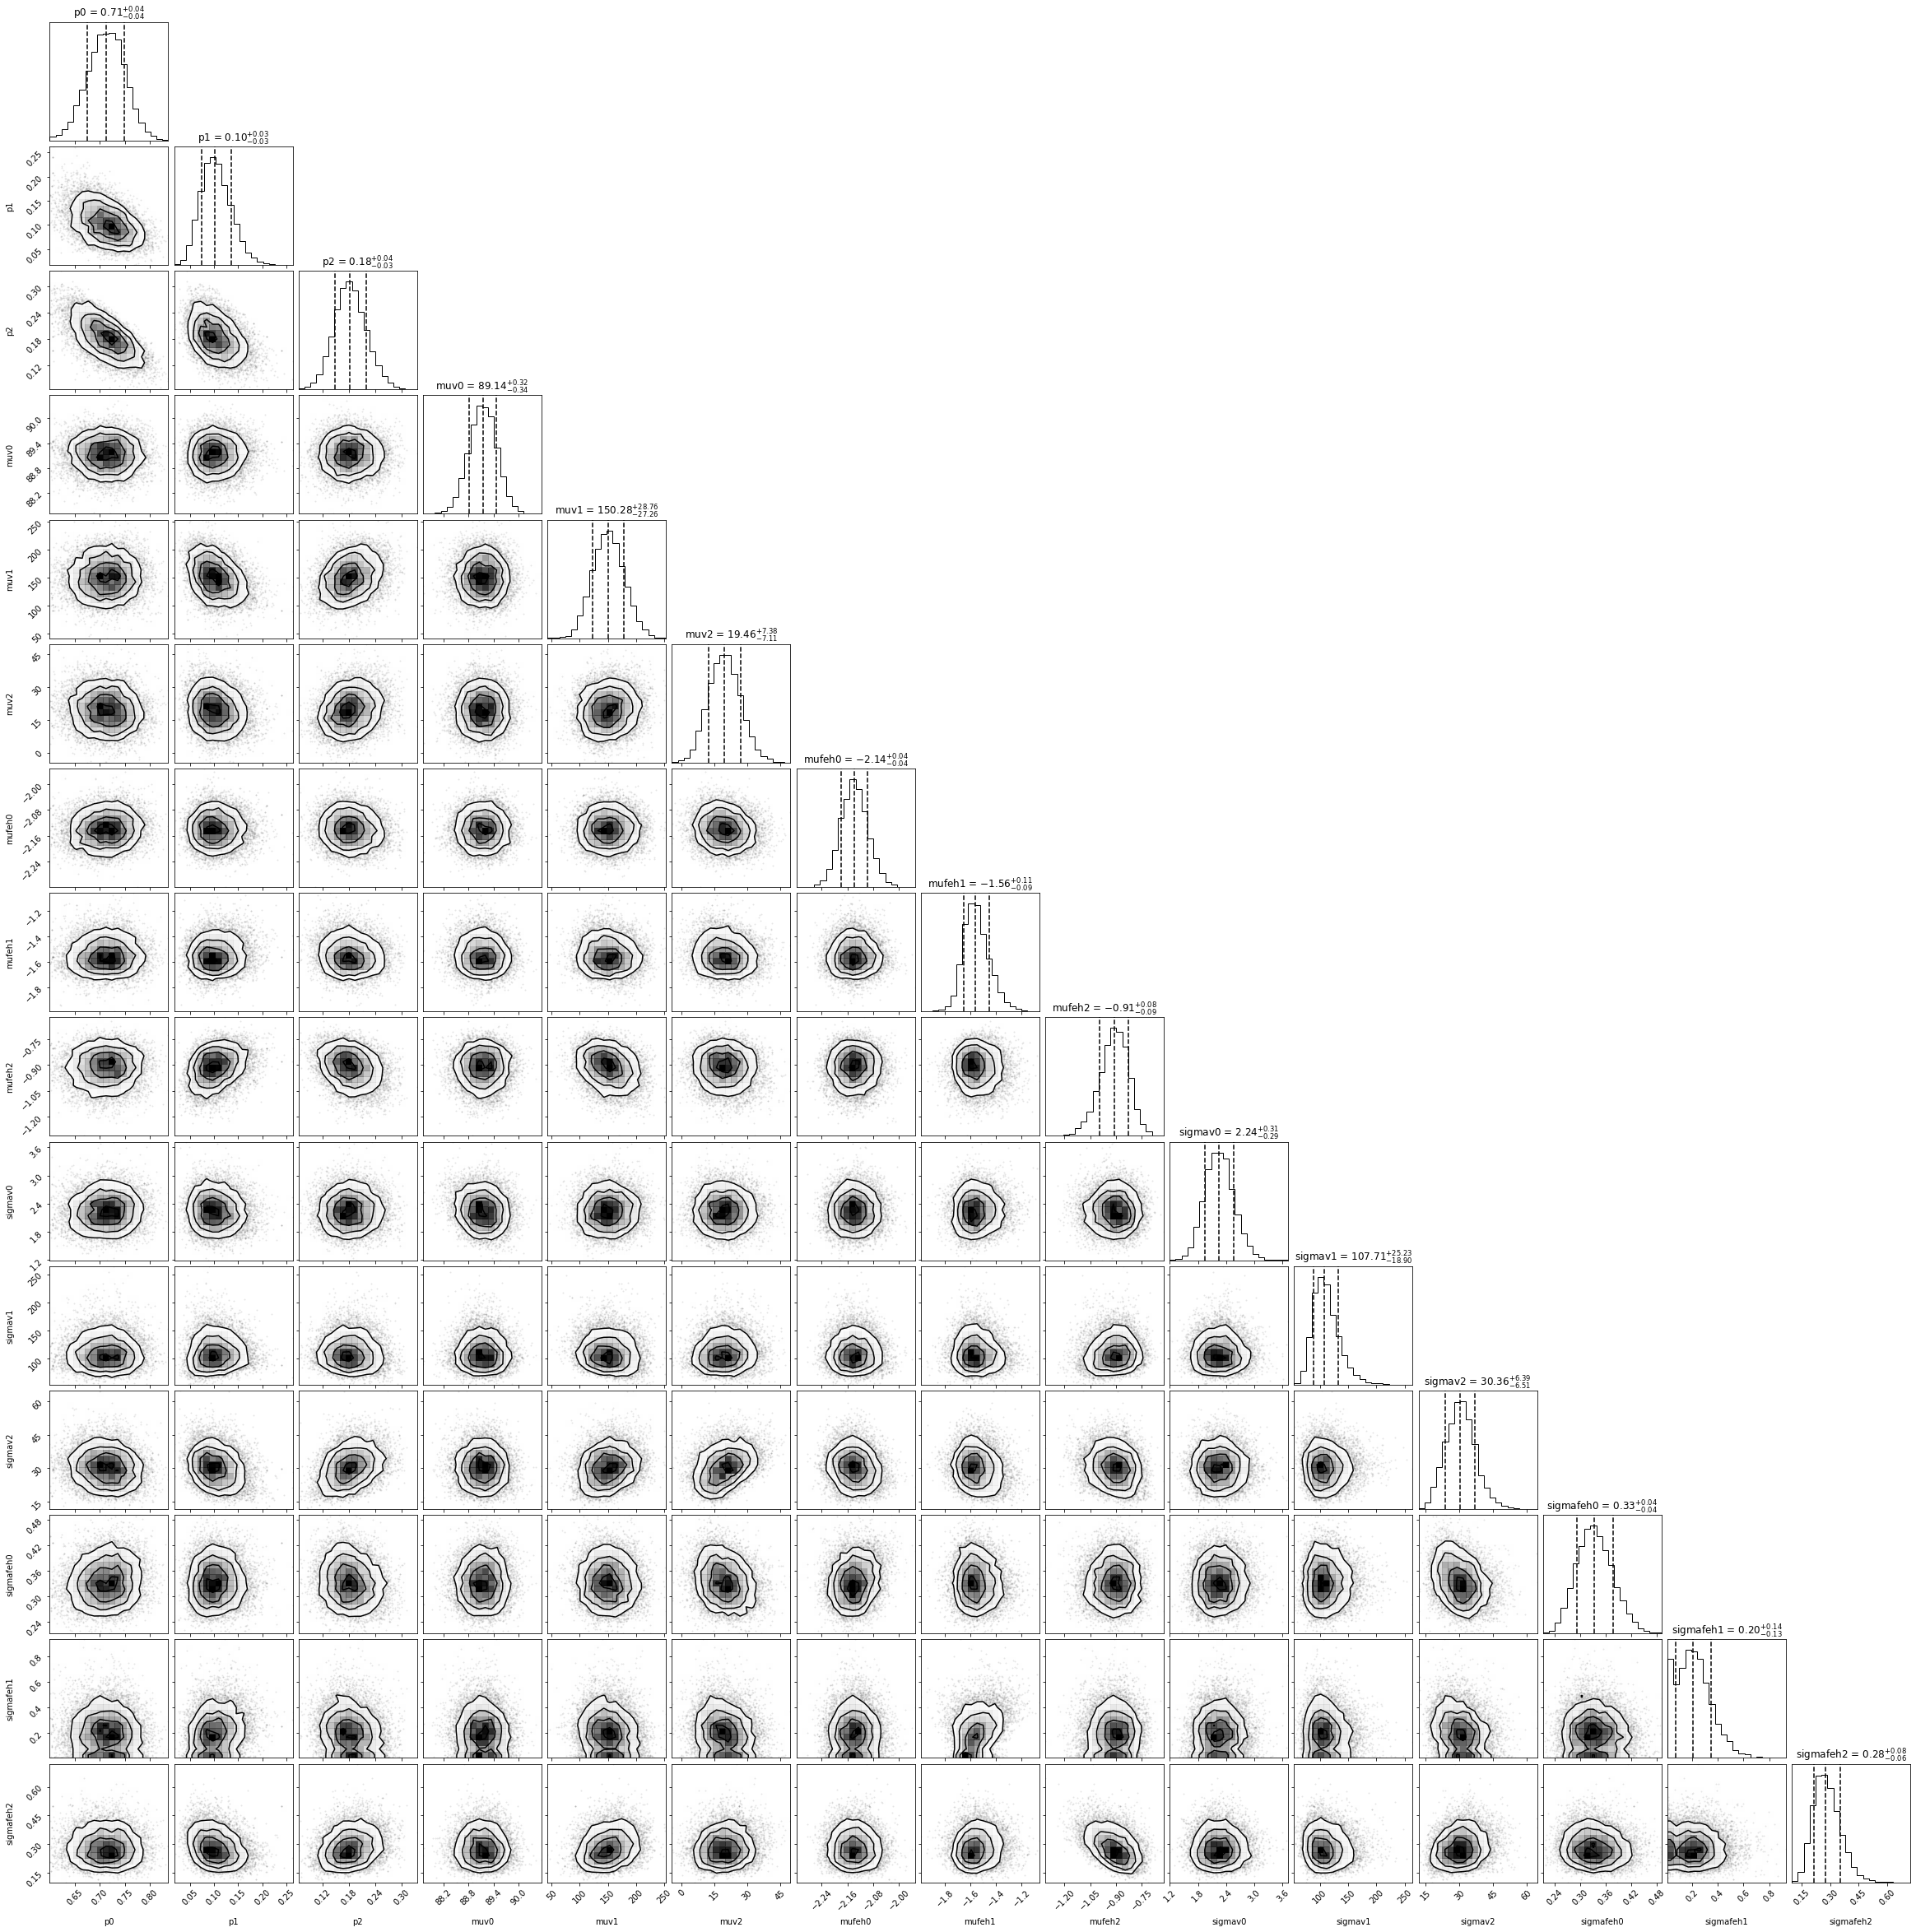

In [17]:
fig = corner.corner(chain, labels=param_labels, quantiles=[0.16,0.50,0.84], show_titles=True)

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

In [18]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [19]:
meds, errs = process_chain(chain)

In [20]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

p0 0.713 0.038
p1 0.102 0.031
p2 0.182 0.036
muv0 89.141 0.329
muv1 150.276 28.011
muv2 19.462 7.248
mufeh0 -2.140 0.042
mufeh1 -1.562 0.100
mufeh2 -0.908 0.083
sigmav0 2.244 0.303
sigmav1 107.714 22.068
sigmav2 30.360 6.448
sigmafeh0 0.333 0.042
sigmafeh1 0.204 0.136
sigmafeh2 0.276 0.070


In [21]:
def get_paramdict(theta):
    ## TODO Update this, it's wrong for this model
    return OrderedDict(zip(param_labels, theta))
def project_model(theta, rvmin=-200, rvmax=500, fehmin=-4, fehmax=1):
    """ Turn parameters into rv and feh distributions """
    params = get_paramdict(theta)
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2, feharr, pfe0, pfe1, pfe2

def plot_1d_distrs(theta):
    ## I'm being lazy and just using the global variables rv, rverr, feh, feherr.
    ## This makes life hard if you need to debug, but oops
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], lw=3)
    ax.plot(xp, p1, ':', color=colors[1], lw=3)
    ax.plot(xp, p0, ':', color=colors[0], lw=3)
    return fig
def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)

    ax.grid()

In [22]:
thetamed = list(meds.values())
fig1 = plot_1d_distrs(thetamed)
fig2 = plot_2d_distr(thetamed)

KeyError: 'pgal'